In [29]:
from torch import nn
import numpy as np

class TransferFeatures(nn.Module):
    def __init__(self, pretrainedModel, classifier):
        super(TransferFeatures, self).__init__()

        self.features = pretrainedModel.features
        self.classifier = classifier

        # Freeze those weights
        for p in self.features.parameters():
            p.requires_grad = False

    def forward(self, x):
        f = self.features(x)
        # flatten network
        f = f.view(f.size(0), np.prod(f.shape[1:]))
        y = self.classifier(f)
        return y

In [30]:
from PIL import Image
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torchvision import models
from torchvision import datasets
import torch.optim as optim

def transform(img):
    img = img.resize((224, 224)).convert('RGB')
    tensor = ToTensor()(img)
    return tensor

trainSet = datasets.MNIST(
    root = 'data',
    train = True,
    download=True,
    transform = transform,
)

batch = 4
trainLoader = torch.utils.data.DataLoader(
    trainSet,
    batch_size=batch,
    shuffle=True
)

classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

In [31]:
from PIL import Image
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torchvision import models
from torchvision import datasets
import torch.optim as optim


model = models.alexnet(pretrained=True)

classifier = nn.Sequential(
    nn.Dropout(),
    nn.Linear(9216, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 10),
)

transferedModel = TransferFeatures(model, classifier)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(transferedModel.parameters(), lr=0.001, momentum=0.9)

In [32]:
# Trenowanie sieci
noEpochs = 2
prev_epoch = 1
loss_vals=  []
for epoch in range(noEpochs):

    epoch_loss= []
    print("Starting epoch ", epoch + 1)

    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = transferedModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))

torch.save(transferedModel, 'transferedV4.pth')
print('Finished Training')

Starting epoch  1


KeyboardInterrupt: 

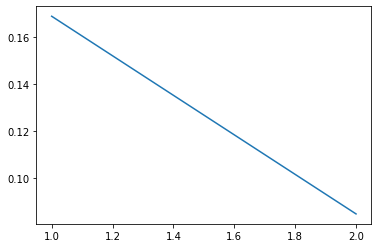

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(1, noEpochs, noEpochs).astype(int), loss_vals)

In [3]:
def transform(img):
    img = img.resize((224, 224)).convert('RGB')
    tensor = ToTensor()(img)
    return tensor

# Evaluate model
testSet = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transform,
)

batch = 4

testLoader = torch.utils.data.DataLoader(testSet,batch_size=batch,shuffle=True)

RuntimeError: Dataset not found. You can use download=True to download it

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

model = torch.load('transferedV4.pth')

model.eval()
y_trues = []
y_preds = []
torch.multiprocessing.set_sharing_strategy('file_system')

for i, data in enumerate(testLoader, 0):
    inputs, labels = data
    
    y_trues.append(int(labels[0]))
    out = model(inputs)
    # get the most probable label
    _, index = torch.topk(out, 1)
    y_preds.append(int(index[0]))


print(confusion_matrix(y_trues,
                       y_preds))


print(classification_report(y_trues,
                            y_preds))

[[233   0   0   0   0   0   0   0   0   0]
 [  0 285   0   0   0   0   0   0   0   0]
 [  2   0 278   4   0   0   0   0   0   0]
 [  0   0   0 227   0   3   0   0   0   0]
 [  0   1   0   0 244   0   0   0   1   1]
 [  0   0   0   0   0 237   0   0   1   0]
 [  2   0   0   0   0   1 242   0   0   0]
 [  0   2   2   0   0   0   0 256   0   0]
 [  2   0   0   0   0   0   0   0 240   0]
 [  0   2   0   0   1   0   0   2   6 225]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       233
           1       0.98      1.00      0.99       285
           2       0.99      0.98      0.99       284
           3       0.98      0.99      0.98       230
           4       1.00      0.99      0.99       247
           5       0.98      1.00      0.99       238
           6       1.00      0.99      0.99       245
           7       0.99      0.98      0.99       260
           8       0.97      0.99      0.98       242
           9       1.00     

In [ ]:
# Testowanie modelu
with torch.no_grad():
    correctPredictions = 0
    numberOfSamples = 0
    for i, (samples, labels) in enumerate(testLoader):
        # propagacja
        outputs = model(samples)
        _, predictions = torch.max(outputs, 1)
        numberOfSamples += labels.shape[0]
        correctPredictions += (predictions == labels).sum().item()

    # obliczenie skuteczności
    accuracy = 100 * correctPredictions / numberOfSamples
    print('accuracy:', accuracy)

accuracy: 98.64


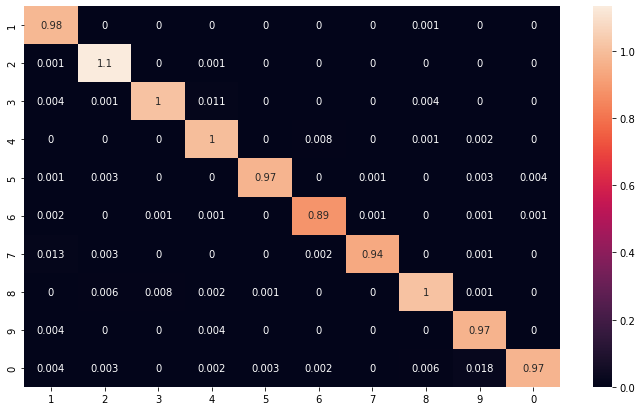

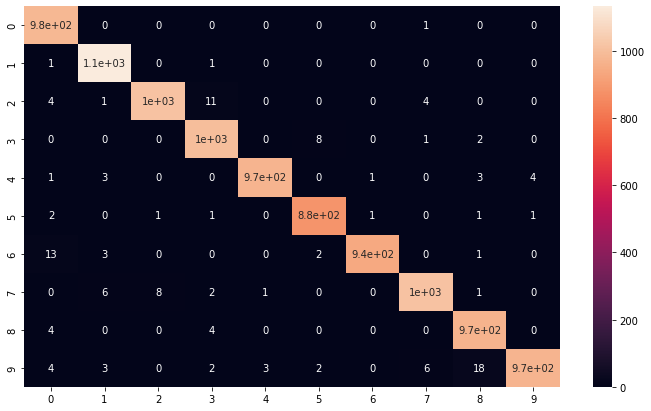

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pred = []
act = []

for samples, labels in testLoader:

    output = model(samples)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    pred.extend(output)
        
    labels = labels.data.cpu().numpy()
    act.extend(labels)

classes = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '0')

# Build confusion matrix
cf_matrix = confusion_matrix(act, pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, 
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('DataFrameTrans4.png')
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)
plt.savefig('ConfMatrixTrans5.png')

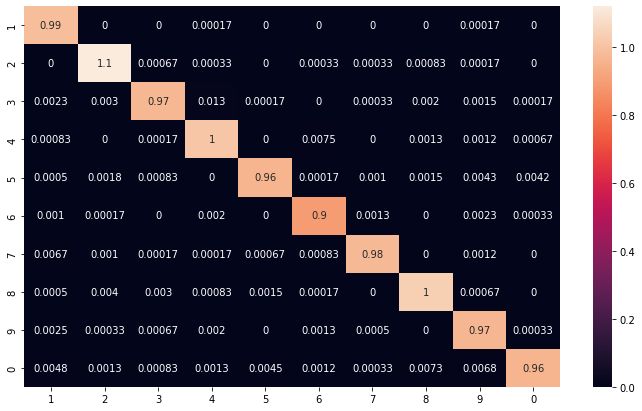

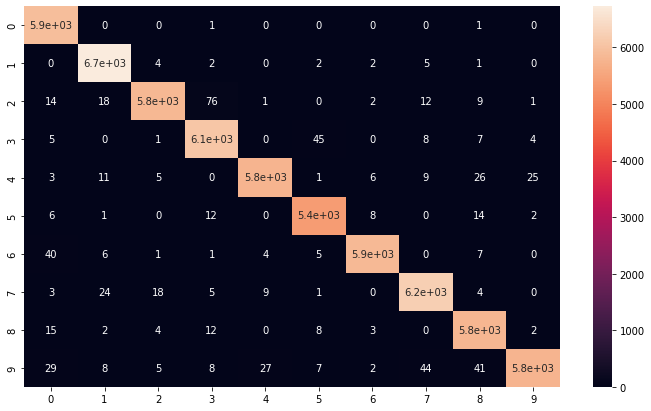

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pred = []
act = []

for samples, labels in trainLoader:

    output = model(samples)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    pred.extend(output)
        
    labels = labels.data.cpu().numpy()
    act.extend(labels)

classes = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '0')

# Build confusion matrix
cf_matrix = confusion_matrix(act, pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, 
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('DataFrameTrans6.png')
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)
plt.savefig('ConfMatrixTrans7.png')

In [1]:
j = 0
# Przykłady złej klasyfikacji
for i, (samples, labels) in enumerate(testLoader):

    output = model(samples)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    pred.extend(output)
        
    labels = labels.data.cpu().numpy()
    act.extend(labels)

    if output[j] != labels[j]:
        text = 'Predicted: ', output[j], ' , Actual: ', labels[j]

        img = samples[j][0]

        plt.figure()
        plt.imshow(img, cmap="gray")
        plt.text(0, 250, text)

    j+=1
    if (j >= 4):
        j = 0

NameError: name 'testLoader' is not defined